<a href="https://colab.research.google.com/github/potulabe/symphonypy/blob/main/notebooks/Symphonypy_without_harmony_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symphonypy usage with your own reference without batch

In [ ]:
!pip install scanpy[leiden] openTSNE symphonypy
!gdown "1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t"

In [2]:
import scanpy as sc
import symphonypy as sp

sc.set_figure_params(dpi=150)

adata_ref = sc.read_h5ad("PBMC_Satija.h5ad")
adata_ref = adata_ref[adata_ref.obs.donor == "P1"]
adata_ref.obs.head()

,orig.ident,lane,donor,time,celltype.l1,celltype.l2,celltype.l3,Phase
L1_AAACCCATCTGCGGAC,P1_0,L1,P1,0,CD4 T,CD4 TCM,CD4 TCM_1,S
L1_AAACGAAAGTTACTCG,P1_0,L1,P1,0,CD4 T,CD4 TCM,CD4 TCM_3,G1
L1_AAACGCTAGGTCGTCC,P1_0,L1,P1,0,CD8 T,CD8 TEM,CD8 TEM_2,S
L1_AAAGAACGTATCCTCC,P1_0,L1,P1,0,CD8 T,CD8 Naive,CD8 Naive,S
L1_AAAGAACTCGCTTAAG,P1_0,L1,P1,0,CD4 T,CD4 TCM,CD4 TCM_1,S


Reference preprocessing and preparation for label transfer using Harmony. We recommend using the same normalization factor for reference and query datasets.

In [3]:
sc.pp.normalize_total(adata_ref, target_sum=1e5) # 1e5 will be used for query
sc.pp.log1p(adata_ref)
sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=3000,
)
adata_ref.raw = adata_ref

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
adata_ref = adata_ref[:, adata_ref.var.highly_variable]
sc.pp.scale(adata_ref, max_value=10)
sc.pp.pca(adata_ref, n_comps=30, zero_center=False)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Now let's compute UMAP for futher visualization and its coordinates transfer, and perform clustering with Leiden algorithm.

In [5]:
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.tl.leiden(adata_ref)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


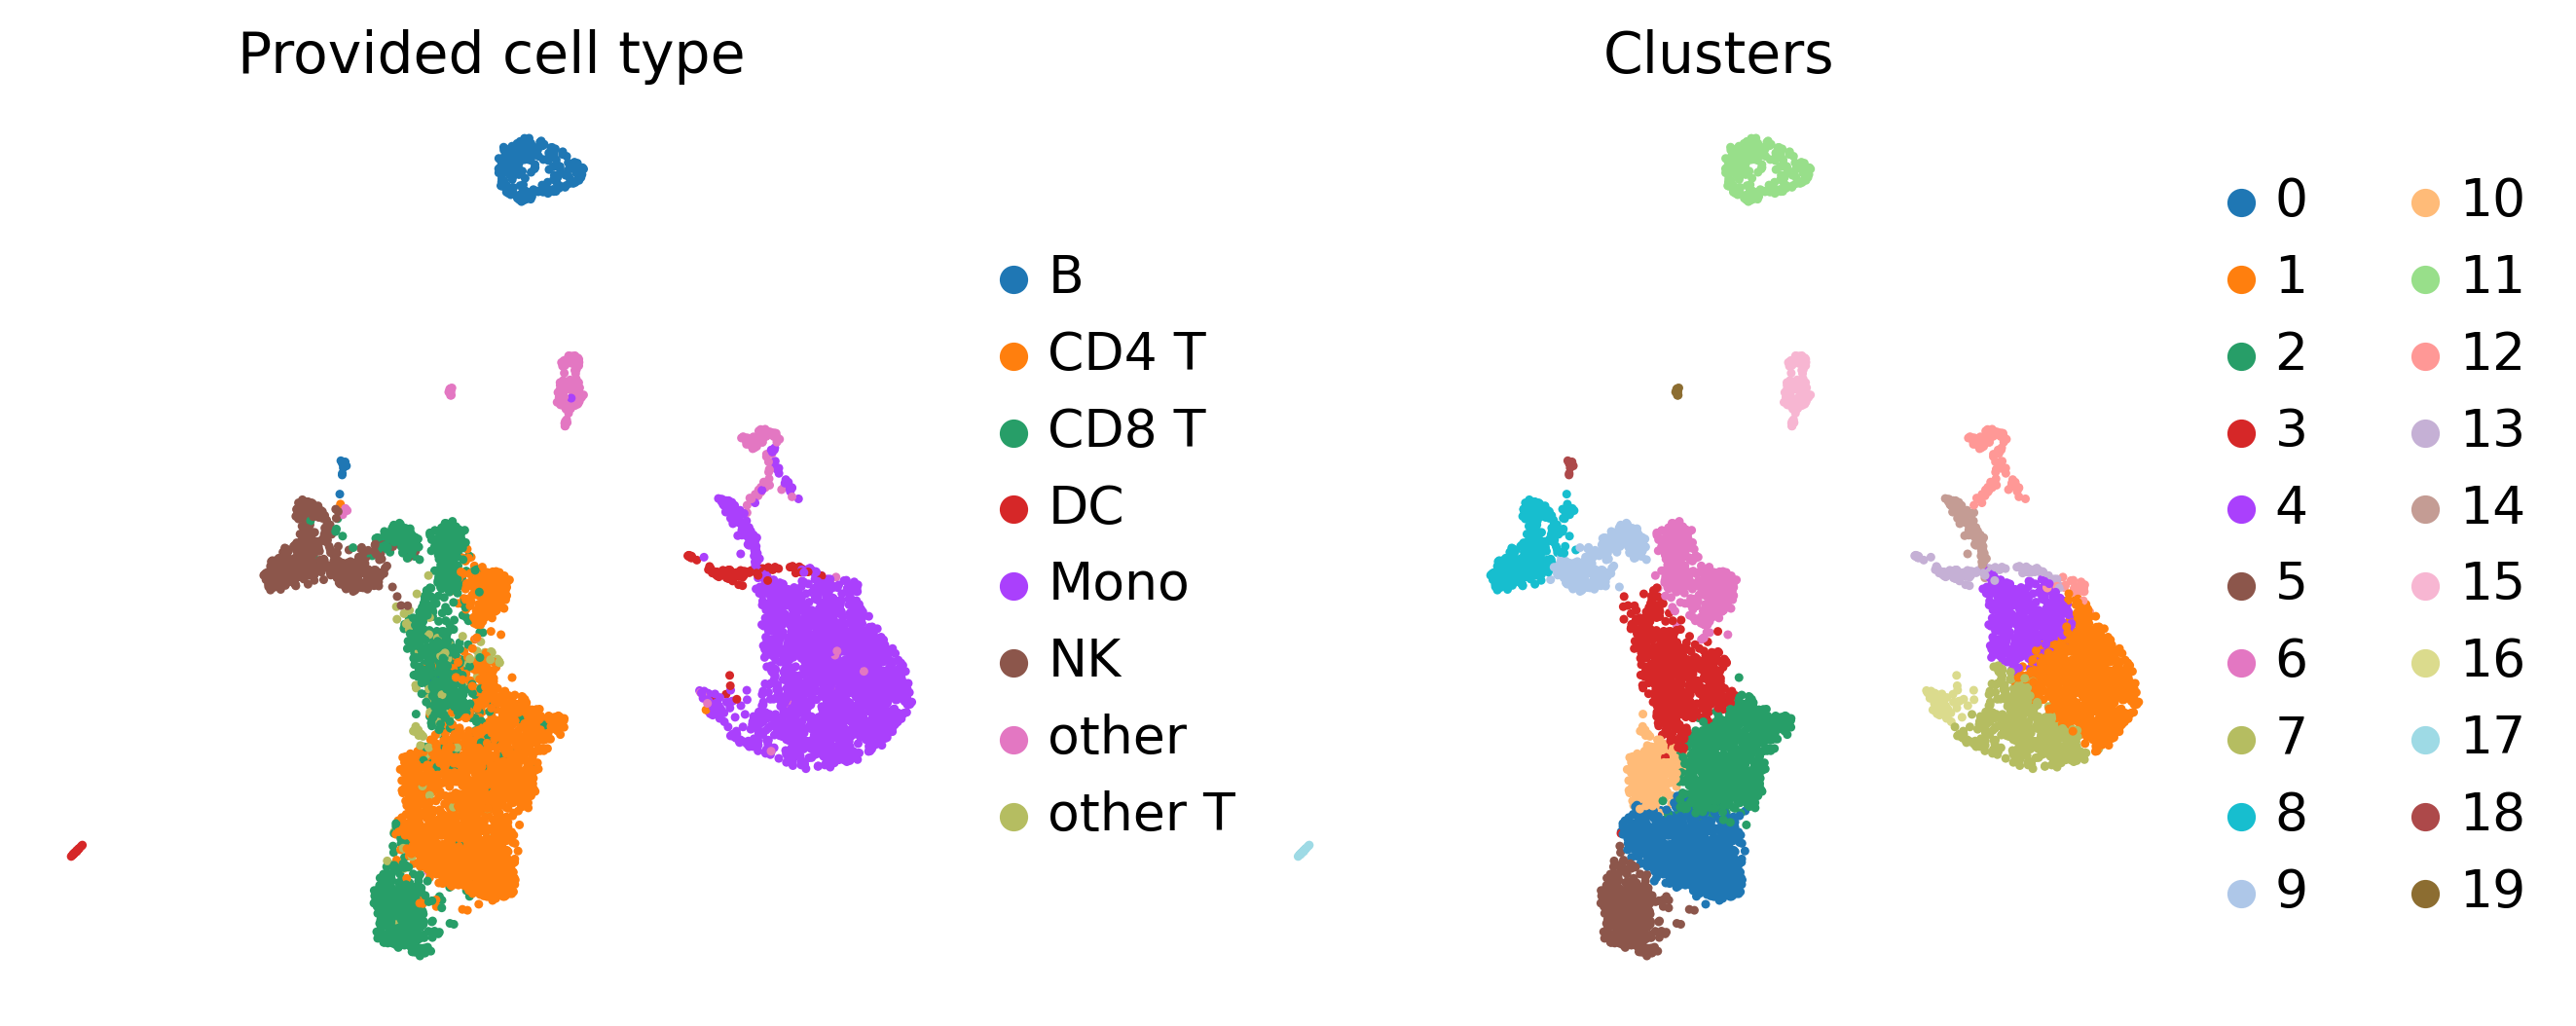

In [6]:
sc.pl.umap(
    adata_ref,
    color=["celltype.l1", "leiden"],
    frameon=False,
    title=["Provided cell type", "Clusters"],
)

## Query mapping and label transfer

In [7]:
adata_query = sc.datasets.pbmc3k()
sc.pp.normalize_total(adata_query, target_sum=1e5)
sc.pp.log1p(adata_query)

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

Let's do embedding mapping and label transfering with symphonypy.

In [8]:
# Running Symphony
sp.tl.map_embedding(
    adata_query=adata_query,
    adata_ref=adata_ref
)

/usr/local/lib/python3.10/dist-packages/symphonypy/tools.py:307: UserWarning: Not found `harmony` object in adata_ref.uns.
Assuming that adata_ref doesn't have any batches, and using 'X_pca' representation of adata_ref for clustering.
Otherwise, firstly run symphonypy.pp.harmony_integrate on adata_ref to account for them.
  warnings.warn(


In [9]:
# Mapping UMAP coordinates
sp.tl.ingest(
    adata_query=adata_query,
    adata_ref=adata_ref,
    use_rep="X_pca_harmony",
)

/usr/local/lib/python3.10/dist-packages/symphonypy/_utils.py:372: UserWarning: 'X_pca' adata_reference's representation was used for reference, while 'X_pca_harmony' was used for query. Be sure that they correspond.
  warnings.warn(


In [10]:
# Labels prediction
sp.tl.transfer_labels_kNN(
    adata_query=adata_query,
    adata_ref=adata_ref,
    ref_labels=["celltype.l1", "leiden"],
    ref_basis="X_pca",
    query_basis="X_pca_harmony",
)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Reference dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

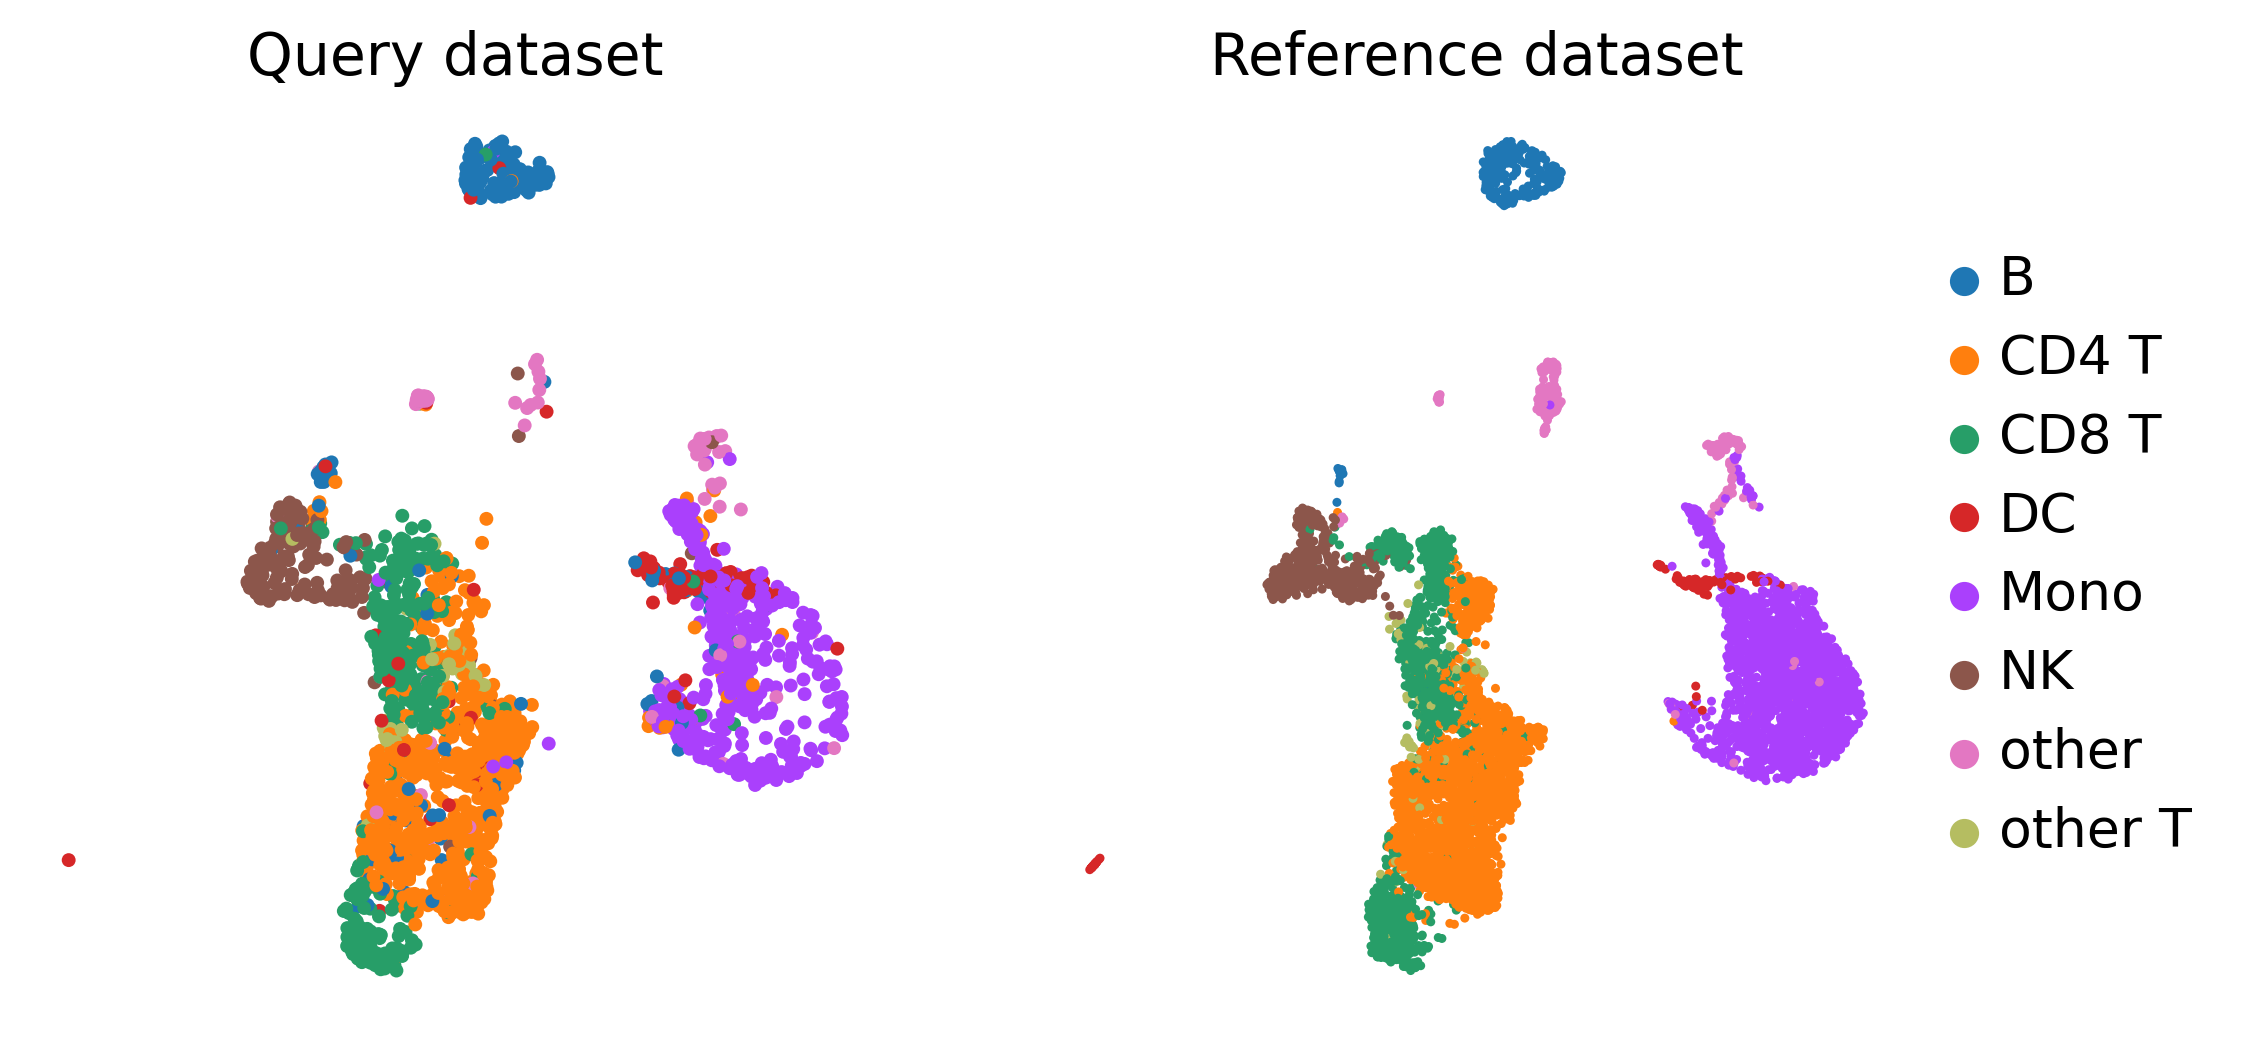

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.umap(
    adata_query,
    color="celltype.l1",
    frameon=False,
    title="Query dataset",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    adata_ref,
    color="celltype.l1",
    frameon=False,
    title="Reference dataset",
    ax=axes[1],
    show=False,
)


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


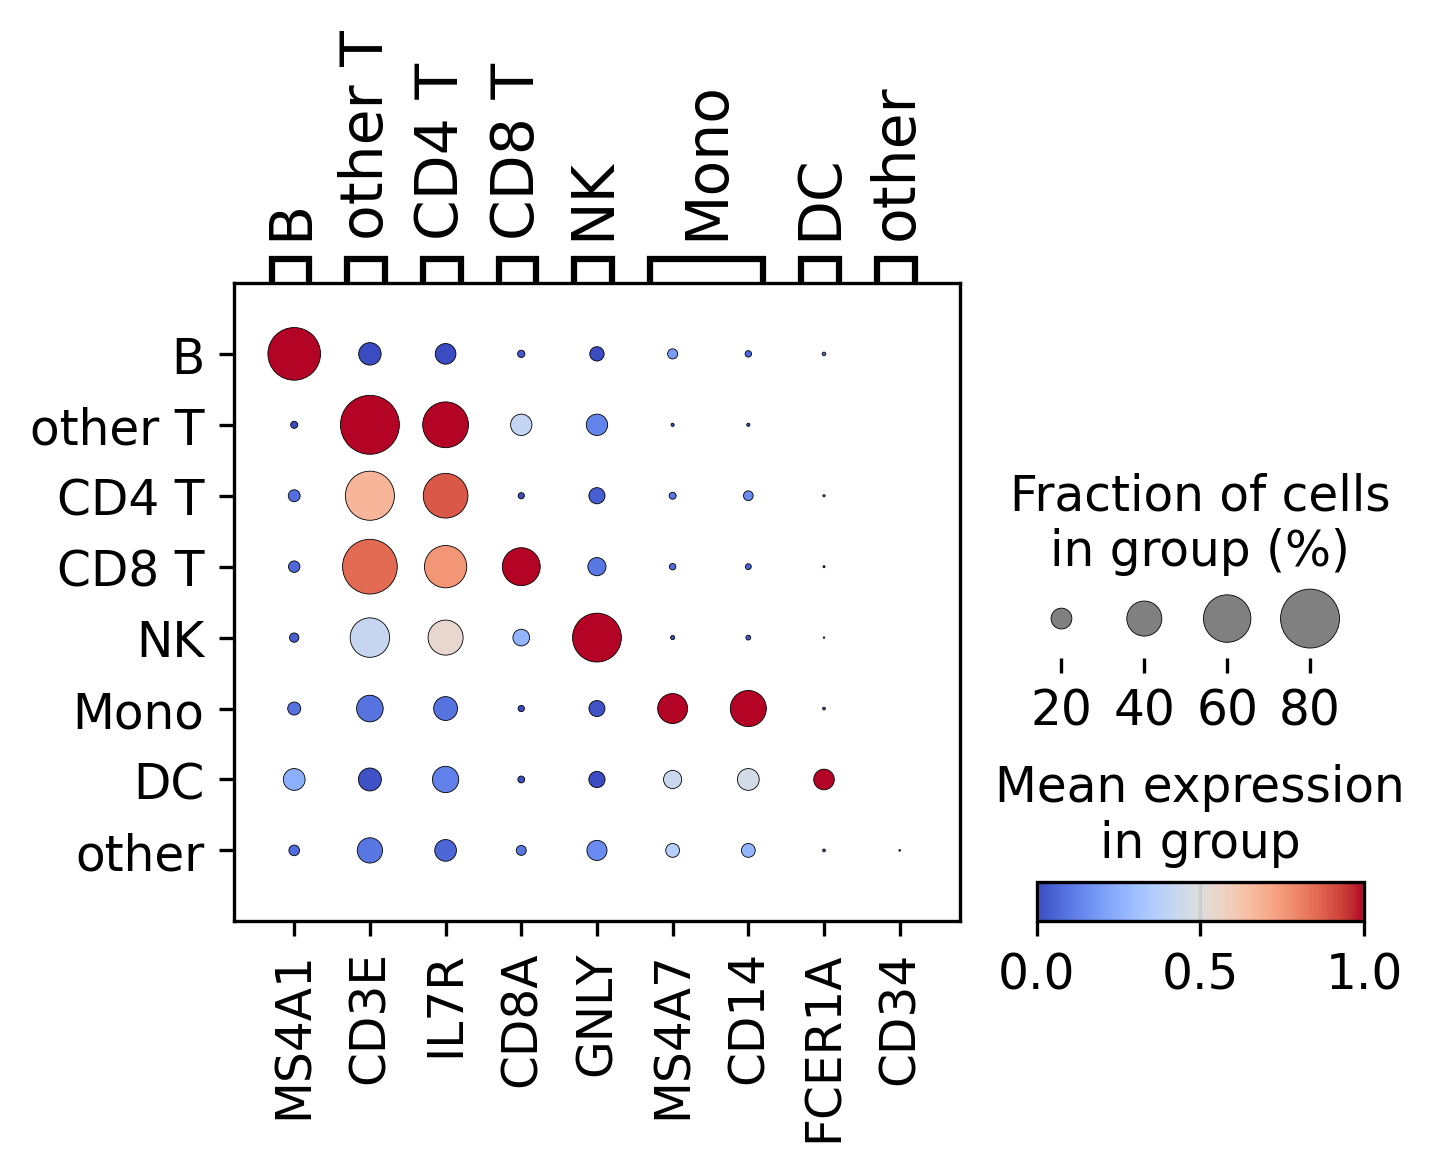

In [12]:
marker_genes = {
    "B": ["MS4A1"],
    "other T": ["CD3E"],
    "CD4 T": ["IL7R"],
    "CD8 T": ["CD8A"],
    "NK": ["GNLY"],
    "Mono": ["MS4A7", "CD14"],
    "DC": ["FCER1A"],
    "other": ["CD34"],
}

adata_query.obs["celltype.l1"] = (
    adata_query.
    obs["celltype.l1"].
    cat.
    reorder_categories(
        list(marker_genes.keys())
    )
)

sc.pl.dotplot(
    adata_query,
    var_names=marker_genes,
    groupby="celltype.l1",
    standard_scale="var",
    dot_max=0.8,
    cmap="coolwarm",
)